In [6]:
import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

import sys
sys.path.append('../scripts')
from nano_gpt import GPT2Model, GPT2Config

from utils import aggregate_metrics, get_model, eval_unlooped_model, eval_looped_model

In [7]:
device = torch.device('cuda:0')

In [8]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

## Get dataset

In [9]:
class Relu2nnRegression():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, hidden_layer_size=100, non_sparse=100):
        super(Relu2nnRegression, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.n_dims = n_dims
        self.n_dims_truncated = n_dims_truncated
        self.b_size = batch_size
        self.n_points = n_points

        W1 = torch.randn(self.b_size, self.n_dims, hidden_layer_size, device=device)
        W2 = torch.randn(self.b_size, hidden_layer_size, 1, device=device)

        if non_sparse < hidden_layer_size:
            import random
            non_sparse_mask = torch.zeros(hidden_layer_size, device=device)
            non_sparse_indices = random.sample(range(hidden_layer_size), non_sparse)
            non_sparse_mask[non_sparse_indices] = 1
            self.W1 = W1 * non_sparse_mask[None, None, :]
            self.W2 = W2 * non_sparse_mask[None, :, None]
        else:
            self.W1 = W1
            self.W2 = W2

        self.xs = torch.randn(batch_size, n_points, n_dims, device=device)  # [B, n, d]
        self.xs[..., n_dims_truncated:] = 0

        self.ys = self.evaluate(self.xs)

    def evaluate(self, xs_b):
        W1 = self.W1
        W2 = self.W2
        # Renormalize to Linear Regression Scale
        ys_b_nn = (F.relu(xs_b @ W1) @ W2)[:, :, 0]
        ys_b_nn = ys_b_nn * math.sqrt(2 / self.hidden_layer_size)
        # ys_b_nn = self.scale * ys_b_nn
        #         ys_b_nn = ys_b_nn * math.sqrt(self.n_dims) / ys_b_nn.std()
        return ys_b_nn
        
        
        
sample_size = 1280
batch_size = 64
n_points = 101
n_dims_truncated = 20
n_dims = 20


torch.manual_seed(456)
real_task = Relu2nnRegression(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys = real_task.xs, real_task.ys

## load model

In [10]:
result_dir = '../results2/relu_2nn_baseline'
run_id = '0623214332-ReLU2NN_baseline-21f1'

from models import TransformerModel

n_positions = 101
n_embd = 256
n_layer = 12
n_head = 8

model = TransformerModel(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err, y_pred_total = eval_unlooped_model(model, xs, ys)


number of parameters: 9.48M


In [11]:
result_errs = {}
result_errs['Transformer'] = err

## Load looped transformer

In [39]:
from models import TransformerModelLooped

result_dir = '../results2/relu_2nn_loop'
run_id = '0706234720-relu2nn_loop_L1_ends{12}_T{5}_all-03f2'

n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)
    
err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

result_errs['Looped Transformer'] = err


number of parameters: 0.79M
0


### Also get the "weak" baseline

In [ ]:
from utils import get_relevant_baselines
from utils import LeastSquaresModel, NNModel, AveragingModel, GDModel, NeuralNetwork
# baselines = get_relevant_baselines("relu_2nn_regression")
baselines = [
    (LeastSquaresModel, {}),
    (NNModel, {"n_neighbors": 3}),
    (AveragingModel, {}),
]
gd_baselines = [
    (GDModel, {
        "model_class": NeuralNetwork,
        "model_class_args": {
            "in_size": 20,
            "hidden_size": 100,
            "out_size": 1,
        },
        "opt_alg": "adam",
        "batch_size": 10,
        "lr": 5e-3,
        "num_steps": 1000,
    },)
]

baselines += gd_baselines          
baseline_models = [model_cls(**kwargs) for model_cls, kwargs in baselines]
# baseline_errs = {}
for baseline_model in baseline_models:
    if "gd_model" in baseline_model.name:
        y_pred = baseline_model(xs, ys, device)
    else:
        y_pred = baseline_model(xs, ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name] = err

In [41]:
result_errs_agg = aggregate_metrics(result_errs, 20)

In [42]:
result_errs_agg['Transformer']['mean']

tensor([1.0195, 0.8751, 0.7929, 0.7043, 0.7007, 0.6716, 0.6306, 0.6171, 0.6213,
        0.5482, 0.5212, 0.5683, 0.5383, 0.5521, 0.5063, 0.4830, 0.4745, 0.4453,
        0.4424, 0.3993, 0.4107, 0.3793, 0.3935, 0.3714, 0.3427, 0.3352, 0.3682,
        0.3544, 0.3422, 0.3420, 0.3204, 0.3185, 0.3123, 0.3086, 0.3128, 0.2881,
        0.3078, 0.2744, 0.2831, 0.2741, 0.2804, 0.2793, 0.2576, 0.2802, 0.2551,
        0.2347, 0.2518, 0.2481, 0.2376, 0.2316, 0.2441, 0.2455, 0.2343, 0.2383,
        0.2091, 0.2355, 0.2322, 0.2350, 0.2386, 0.2089, 0.2084, 0.2284, 0.2095,
        0.2162, 0.2076, 0.2131, 0.2156, 0.2064, 0.2081, 0.2048, 0.1943, 0.2125,
        0.1976, 0.1977, 0.1826, 0.1903, 0.1803, 0.1918, 0.1954, 0.1958, 0.1829,
        0.1850, 0.1817, 0.1768, 0.1860, 0.1946, 0.1785, 0.1792, 0.1694, 0.1680,
        0.1720, 0.1594, 0.1681, 0.1613, 0.1740, 0.1741, 0.1784, 0.1545, 0.1722,
        0.1689, 0.1695])

In [43]:
result_errs_agg['Looped Transformer']['mean']

tensor([1.0179, 0.8802, 0.7955, 0.7053, 0.7005, 0.6690, 0.6358, 0.6174, 0.6261,
        0.5496, 0.5227, 0.5707, 0.5382, 0.5518, 0.5068, 0.4855, 0.4758, 0.4479,
        0.4439, 0.4003, 0.4138, 0.3831, 0.3920, 0.3753, 0.3442, 0.3387, 0.3708,
        0.3565, 0.3437, 0.3473, 0.3255, 0.3179, 0.3151, 0.3188, 0.3178, 0.2907,
        0.3128, 0.2782, 0.2891, 0.2773, 0.2817, 0.2840, 0.2612, 0.2819, 0.2613,
        0.2371, 0.2534, 0.2543, 0.2409, 0.2349, 0.2485, 0.2494, 0.2382, 0.2443,
        0.2179, 0.2398, 0.2385, 0.2391, 0.2477, 0.2154, 0.2161, 0.2326, 0.2153,
        0.2228, 0.2099, 0.2201, 0.2271, 0.2109, 0.2121, 0.2098, 0.1988, 0.2213,
        0.2042, 0.2056, 0.1851, 0.1943, 0.1881, 0.1978, 0.1976, 0.2027, 0.1892,
        0.1917, 0.1917, 0.1863, 0.1893, 0.1985, 0.1826, 0.1863, 0.1802, 0.1761,
        0.1771, 0.1687, 0.1718, 0.1699, 0.1815, 0.1850, 0.1846, 0.1602, 0.1770,
        0.1799, 0.1802])

In [44]:
result_errs.keys()

dict_keys(['Transformer', 'Looped Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging', 'gd_model_opt_alg=adam_lr=0.005_batch_size=10_num_steps=1000'])

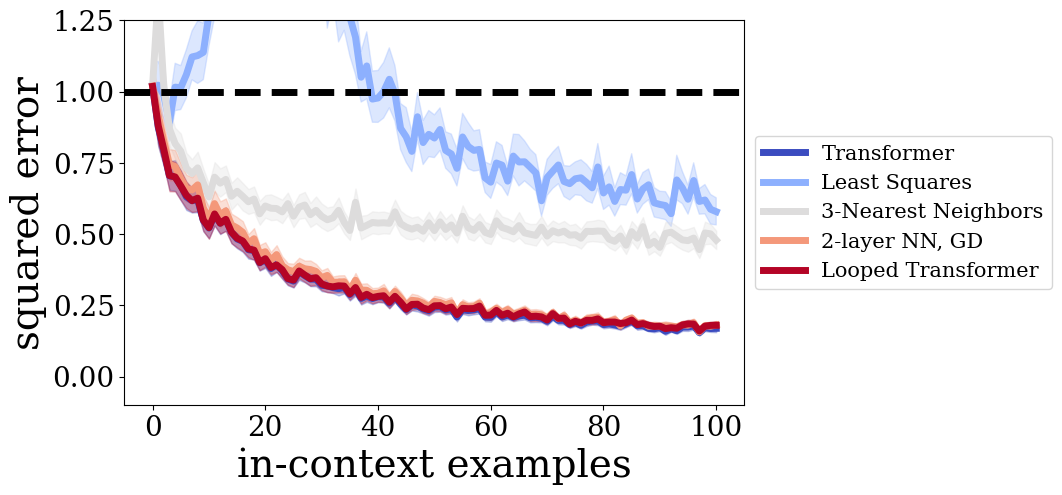

In [47]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = result_errs_agg

cmap = matplotlib.cm.get_cmap("coolwarm")

# result_name_list = ['Transformer', 'Looped Transformer']
# result_name_list = ['Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging', 'Looped Transformer']
result_name_list = ['Transformer', 'Least Squares', '3-Nearest Neighbors', "gd_model_opt_alg=adam_lr=0.005_batch_size=10_num_steps=1000", 'Looped Transformer']
colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    if "gd_model" in model_name:
        label_name = "2-layer NN, GD"
    else:
        label_name = model_name
    if "Looped" in model_name:
        ls = '-'
    else:
        ls = '-'
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=label_name, ls=ls)
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
ax.set_ylim(-0.1, 1.25)
# plt.xticks(np.arange(0, n_points))
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])


plt.savefig("result_folder/Figures/relu2nn_err.pdf", format='pdf', dpi=600, bbox_inches='tight')